# LFW Face Recognition for Repeated Appearances 

Voter Re-Entry/ Repetition

In [24]:
# Cell 1: Install and Import Dependencies

"""
!pip install scikit-learn opencv-python matplotlib numpy
"""

import os
import cv2
import numpy as np
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import pickle
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for inline plotting
%matplotlib inline
plt.style.use('default')

print(" All dependencies imported successfully!")

 All dependencies imported successfully!


In [25]:
# Cell 2: Face Recognition Class Definition
class LFWFaceRecognizer:
    """
    Face recognition system for identifying repeated appearances in LFW dataset
    Optimized for Jupyter notebook usage
    """
    
    def __init__(self, min_faces_per_person=2, similarity_threshold=0.7):
        """
        Initialize the face recognizer
        
        Args:
            min_faces_per_person: Minimum number of faces required per person in dataset
            similarity_threshold: Threshold for face similarity (0-1, higher = more strict)
        """
        self.min_faces_per_person = min_faces_per_person
        self.similarity_threshold = similarity_threshold
        
        # Storage for face encodings and metadata
        self.known_faces = {}  # person_name -> list of face encodings
        self.face_database = []  # List of (encoding, person_name, image_path)
        self.appearance_count = defaultdict(int)
        self.detection_history = []
        
        print(f"🔧 Face Recognizer initialized with threshold: {similarity_threshold}")
        
    def load_lfw_dataset(self):
        """Load and preprocess LFW dataset"""
        print(" Loading LFW dataset...")
        
        # Fetch LFW dataset
        lfw_people = fetch_lfw_people(
            min_faces_per_person=self.min_faces_per_person, 
            resize=0.4, 
            slice_=(slice(70, 195), slice(78, 172))
        )
        
        self.images = lfw_people.images
        self.target_names = lfw_people.target_names
        self.targets = lfw_people.target
        
        print(f" Dataset loaded: {len(self.images)} images of {len(self.target_names)} people")
        
        # Show some sample images
        self.show_sample_images()
        
        return self.images, self.target_names, self.targets
    
    def show_sample_images(self, n_samples=8):
        """Display sample images from the dataset"""
        fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        
        for i, ax in enumerate(axes.flat):
            if i < len(self.images):
                ax.imshow(self.images[i], cmap='gray')
                ax.set_title(f"{self.target_names[self.targets[i]]}")
                ax.axis('off')
        
        plt.suptitle("Sample Images from LFW Dataset", fontsize=14)
        plt.tight_layout()
        plt.show()
    
    def extract_face_features(self, image):
        """
        Extract face features using histogram-based approach
        For better accuracy, consider using deep learning models
        """
        # Normalize image
        if image.max() > 1:
            image = image / 255.0
            
        # Flatten and create feature vector
        flattened = image.flatten()
        
        # Create histogram features
        hist = np.histogram(flattened, bins=50, range=(0, 1))[0]
        
        # Combine raw pixels (downsampled) with histogram
        downsampled = cv2.resize(image, (32, 32)).flatten()
        features = np.concatenate([downsampled, hist])
        
        # Normalize features
        features = features / (np.linalg.norm(features) + 1e-8)
        
        return features
    
    def build_face_database(self, images=None, target_names=None, targets=None):
        """Build database of known faces"""
        if images is None:
            images = self.images
            target_names = self.target_names
            targets = self.targets
            
        print(" Building face database...")
        
        self.face_database = []
        self.known_faces = defaultdict(list)
        
        for i, (image, target) in enumerate(zip(images, targets)):
            person_name = target_names[target]
            
            # Extract features
            features = self.extract_face_features(image)
            
            # Store in database
            self.face_database.append((features, person_name, f"image_{i}"))
            self.known_faces[person_name].append(features)
            
            # Progress indicator
            if (i + 1) % 100 == 0:
                print(f"  Processed {i + 1}/{len(images)} images...")
        
        print(f" Database built with {len(self.face_database)} face encodings")
        print(f" People in database: {len(self.known_faces)}")
        
        # Show database statistics
        self.show_database_stats()
    
    def show_database_stats(self):
        """Display database statistics"""
        face_counts = [len(faces) for faces in self.known_faces.values()]
        
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(face_counts, bins=20, alpha=0.7, color='skyblue')
        plt.xlabel('Number of Images per Person')
        plt.ylabel('Frequency')
        plt.title('Distribution of Images per Person')
        
        plt.subplot(1, 2, 2)
        top_people = sorted(self.known_faces.items(), key=lambda x: len(x[1]), reverse=True)[:10]
        names = [name[:15] for name, _ in top_people]  # Truncate long names
        counts = [len(faces) for _, faces in top_people]
        
        plt.barh(names, counts, color='lightcoral')
        plt.xlabel('Number of Images')
        plt.title('Top 10 People by Image Count')
        
        plt.tight_layout()
        plt.show()
    
    def identify_face(self, query_image, return_confidence=False):
        """
        Identify a face in the query image
        
        Args:
            query_image: Input image to identify
            return_confidence: Whether to return confidence score
            
        Returns:
            person_name or None if no match found
        """
        # Extract features from query image
        query_features = self.extract_face_features(query_image)
        
        best_match = None
        best_similarity = 0
        
        # Compare with all known faces
        for features, person_name, _ in self.face_database:
            similarity = cosine_similarity([query_features], [features])[0][0]
            
            if similarity > best_similarity:
                best_similarity = similarity
                best_match = person_name
        
        # Check if similarity meets threshold
        if best_similarity >= self.similarity_threshold:
            if return_confidence:
                return best_match, best_similarity
            return best_match
        
        if return_confidence:
            return None, best_similarity
        return None
    
    def process_image_sequence(self, images, image_names=None, show_alerts=True):
        """
        Process a sequence of images and track repeated appearances
        
        Args:
            images: List of images to process
            image_names: Optional list of image names/paths
            show_alerts: Whether to print alerts for repeated appearances
        """
        print(f" Processing {len(images)} images for repeated appearances...")
        
        self.appearance_count = defaultdict(int)
        self.detection_history = []
        
        for i, image in enumerate(images):
            image_name = image_names[i] if image_names else f"image_{i}"
            
            # Identify face
            identified_person, confidence = self.identify_face(image, return_confidence=True)
            
            if identified_person:
                self.appearance_count[identified_person] += 1
                
                # Record detection
                detection_info = {
                    'image_index': i,
                    'image_name': image_name,
                    'person': identified_person,
                    'confidence': confidence,
                    'appearance_count': self.appearance_count[identified_person]
                }
                self.detection_history.append(detection_info)
                
                # Alert for repeated appearance
                if show_alerts and self.appearance_count[identified_person] > 1:
                    print(f" ALERT: {identified_person} detected again! "
                          f"(Appearance #{self.appearance_count[identified_person]}) "
                          f"in {image_name} (confidence: {confidence:.3f})")
            else:
                if show_alerts:
                    print(f" Unknown person in {image_name} (confidence: {confidence:.3f})")
                    
        print(f" Processing complete! Found {len(self.detection_history)} identifications")
    
    def get_appearance_summary(self):
        """Get summary of all appearances"""
        print("\n APPEARANCE SUMMARY:")
        print("-" * 60)
        
        if not self.appearance_count:
            print("No appearances detected!")
            return {}
        
        # Sort by appearance count
        sorted_appearances = sorted(self.appearance_count.items(), 
                                  key=lambda x: x[1], reverse=True)
        
        repeated_count = 0
        for person, count in sorted_appearances:
            status = " REPEATED" if count > 1 else " Single"
            print(f"{person}: {count} appearances {status}")
            if count > 1:
                repeated_count += 1
        
        print(f"\n Statistics:")
        print(f"  • Total people detected: {len(self.appearance_count)}")
        print(f"  • People with multiple appearances: {repeated_count}")
        print(f"  • Total detections: {sum(self.appearance_count.values())}")
        
        return dict(self.appearance_count)
    
    def visualize_repeated_appearances(self, images, max_persons=5):
        """Visualize people who appear multiple times"""
        repeated_people = {k: v for k, v in self.appearance_count.items() if v > 1}
        
        if not repeated_people:
            print(" No repeated appearances found!")
            return
        
        print(f" Visualizing {len(repeated_people)} people with multiple appearances")
        
        # Sort by appearance count
        sorted_repeated = sorted(repeated_people.items(), 
                               key=lambda x: x[1], reverse=True)[:max_persons]
        
        for person_idx, (person, count) in enumerate(sorted_repeated):
            # Find images of this person
            person_detections = [d for d in self.detection_history if d['person'] == person]
            
            n_images = min(count, 6)  # Show max 6 images
            cols = min(n_images, 3)
            rows = (n_images - 1) // cols + 1
            
            fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
            if rows == 1 and cols == 1:
                axes = [axes]
            elif rows == 1:
                axes = [axes]
            else:
                axes = axes.flatten()
            
            for img_idx, detection in enumerate(person_detections[:n_images]):
                ax = axes[img_idx]
                image_index = detection['image_index']
                ax.imshow(images[image_index], cmap='gray')
                ax.set_title(f"Appearance #{detection['appearance_count']}\n"
                           f"Confidence: {detection['confidence']:.3f}")
                ax.axis('off')
            
            # Hide unused subplots
            for idx in range(n_images, len(axes)):
                axes[idx].axis('off')
            
            plt.suptitle(f"{person} - {count} appearances", fontsize=14, y=0.98)
            plt.tight_layout()
            plt.show()
    
    def create_detection_timeline(self):
        """Create a timeline visualization of detections"""
        if not self.detection_history:
            print("No detections to visualize!")
            return
        
        fig, ax = plt.subplots(figsize=(15, 6))
        
        # Get unique people and assign colors
        people = list(set(d['person'] for d in self.detection_history))
        colors = plt.cm.Set3(np.linspace(0, 1, len(people)))
        color_map = dict(zip(people, colors))
        
        # Plot timeline
        for detection in self.detection_history:
            person = detection['person']
            x = detection['image_index']
            y = people.index(person)
            
            # Size based on confidence
            size = 100 + (detection['confidence'] * 300)
            
            # Color based on appearance count
            alpha = 0.6 if detection['appearance_count'] == 1 else 1.0
            
            ax.scatter(x, y, s=size, c=[color_map[person]], alpha=alpha, 
                      edgecolors='black', linewidth=1)
            
            # Add appearance count as text
            ax.text(x, y, str(detection['appearance_count']), 
                   ha='center', va='center', fontsize=8, fontweight='bold')
        
        ax.set_xlabel('Image Index')
        ax.set_ylabel('Person')
        ax.set_yticks(range(len(people)))
        ax.set_yticklabels([p[:20] for p in people])  # Truncate long names
        ax.set_title('Detection Timeline (Size = Confidence, Number = Appearance Count)')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def save_model(self, filepath):
        """Save the trained model"""
        model_data = {
            'known_faces': dict(self.known_faces),
            'face_database': self.face_database,
            'similarity_threshold': self.similarity_threshold,
            'target_names': self.target_names,
            'appearance_count': dict(self.appearance_count),
            'detection_history': self.detection_history
        }
        
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        print(f" Model saved to {filepath}")
    
    def load_model(self, filepath):
        """Load a trained model"""
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        
        self.known_faces = model_data['known_faces']
        self.face_database = model_data['face_database']
        self.similarity_threshold = model_data['similarity_threshold']
        self.target_names = model_data['target_names']
        self.appearance_count = defaultdict(int, model_data.get('appearance_count', {}))
        self.detection_history = model_data.get('detection_history', [])
        
        print(f" Model loaded from {filepath}")

print(" LFWFaceRecognizer class defined successfully!")

 LFWFaceRecognizer class defined successfully!


🚀 Starting Face Recognition System
🔧 Face Recognizer initialized with threshold: 0.65
 Loading LFW dataset...
 Dataset loaded: 9164 images of 1680 people


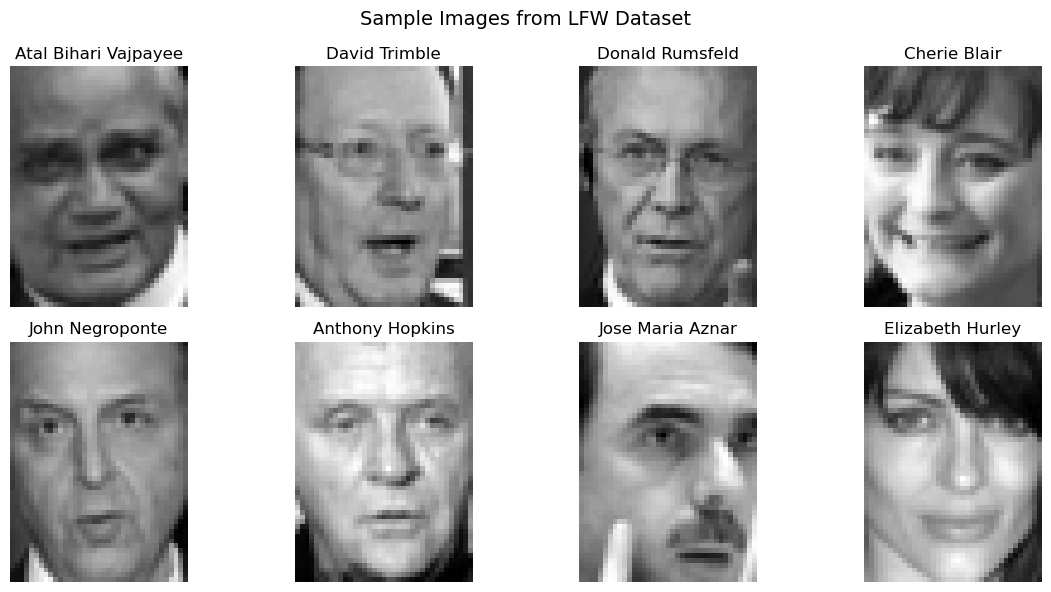

In [26]:
# Cell 3: Initialize and Load Dataset
# Initialize the face recognizer
print("🚀 Starting Face Recognition System")
print("=" * 50)

recognizer = LFWFaceRecognizer(
    min_faces_per_person=2,  # Minimum faces per person
    similarity_threshold=0.65  # Adjust this value (0.6-0.8 recommended)
)

# Load the LFW dataset
images, target_names, targets = recognizer.load_lfw_dataset()

 Building face database...
  Processed 100/9164 images...
  Processed 200/9164 images...
  Processed 300/9164 images...
  Processed 400/9164 images...
  Processed 500/9164 images...
  Processed 600/9164 images...
  Processed 700/9164 images...
  Processed 800/9164 images...
  Processed 900/9164 images...
  Processed 1000/9164 images...
  Processed 1100/9164 images...
  Processed 1200/9164 images...
  Processed 1300/9164 images...
  Processed 1400/9164 images...
  Processed 1500/9164 images...
  Processed 1600/9164 images...
  Processed 1700/9164 images...
  Processed 1800/9164 images...
  Processed 1900/9164 images...
  Processed 2000/9164 images...
  Processed 2100/9164 images...
  Processed 2200/9164 images...
  Processed 2300/9164 images...
  Processed 2400/9164 images...
  Processed 2500/9164 images...
  Processed 2600/9164 images...
  Processed 2700/9164 images...
  Processed 2800/9164 images...
  Processed 2900/9164 images...
  Processed 3000/9164 images...
  Processed 3100/9164 

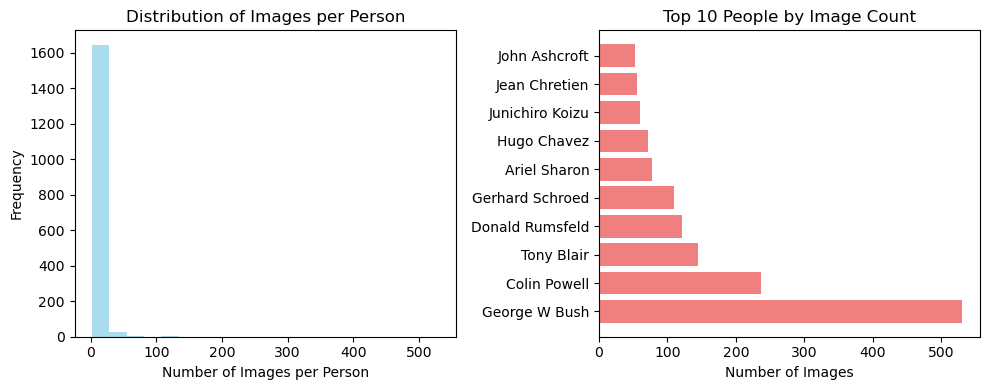

In [27]:
# Cell 4: Build Face Database
# Build the face database from the loaded images
recognizer.build_face_database()

In [29]:
# Cell 5: Create Test Sequence
# Create a test sequence with some repeated faces
print(" Creating test sequence with repeated appearances...")

# Select specific indices to ensure some repetitions
np.random.seed(42)  # For reproducible results
test_indices = []

# Add some random images
random_indices = np.random.choice(len(images), size=30, replace=False)
test_indices.extend(random_indices)

# Add some repeated appearances (same person multiple times)
repeat_indices = np.random.choice(random_indices, size=10, replace=True)
test_indices.extend(repeat_indices)

# Shuffle the sequence
np.random.shuffle(test_indices)

# Create test images and names
test_images = [images[i] for i in test_indices]
test_names = [f"sequence_image_{i:03d}" for i in range(len(test_indices))]

print(f" Test sequence created with {len(test_images)} images")
print(f"   Original images: 30, Repeated images: 10")

 Creating test sequence with repeated appearances...
 Test sequence created with 40 images
   Original images: 30, Repeated images: 10


In [30]:
# Cell 6: Process Image Sequence
# Process the test sequence
print("\n Processing image sequence...")
recognizer.process_image_sequence(test_images, test_names, show_alerts=True)


 Processing image sequence...
 Processing 40 images for repeated appearances...
 ALERT: Bijan Darvish detected again! (Appearance #2) in sequence_image_021 (confidence: 1.000)
 ALERT: Vaclav Havel detected again! (Appearance #2) in sequence_image_022 (confidence: 1.000)
 ALERT: George W Bush detected again! (Appearance #2) in sequence_image_023 (confidence: 1.000)
 ALERT: George W Bush detected again! (Appearance #3) in sequence_image_026 (confidence: 1.000)
 ALERT: Rick Dinse detected again! (Appearance #2) in sequence_image_028 (confidence: 1.000)
 ALERT: Maria Luisa Mendonca detected again! (Appearance #2) in sequence_image_030 (confidence: 1.000)
 ALERT: Lucio Gutierrez detected again! (Appearance #2) in sequence_image_031 (confidence: 1.000)
 ALERT: Guillermo Coria detected again! (Appearance #2) in sequence_image_033 (confidence: 1.000)
 ALERT: Britney Spears detected again! (Appearance #2) in sequence_image_034 (confidence: 1.000)
 ALERT: Kieran Prendergast detected again! (App


 Detection Timeline:


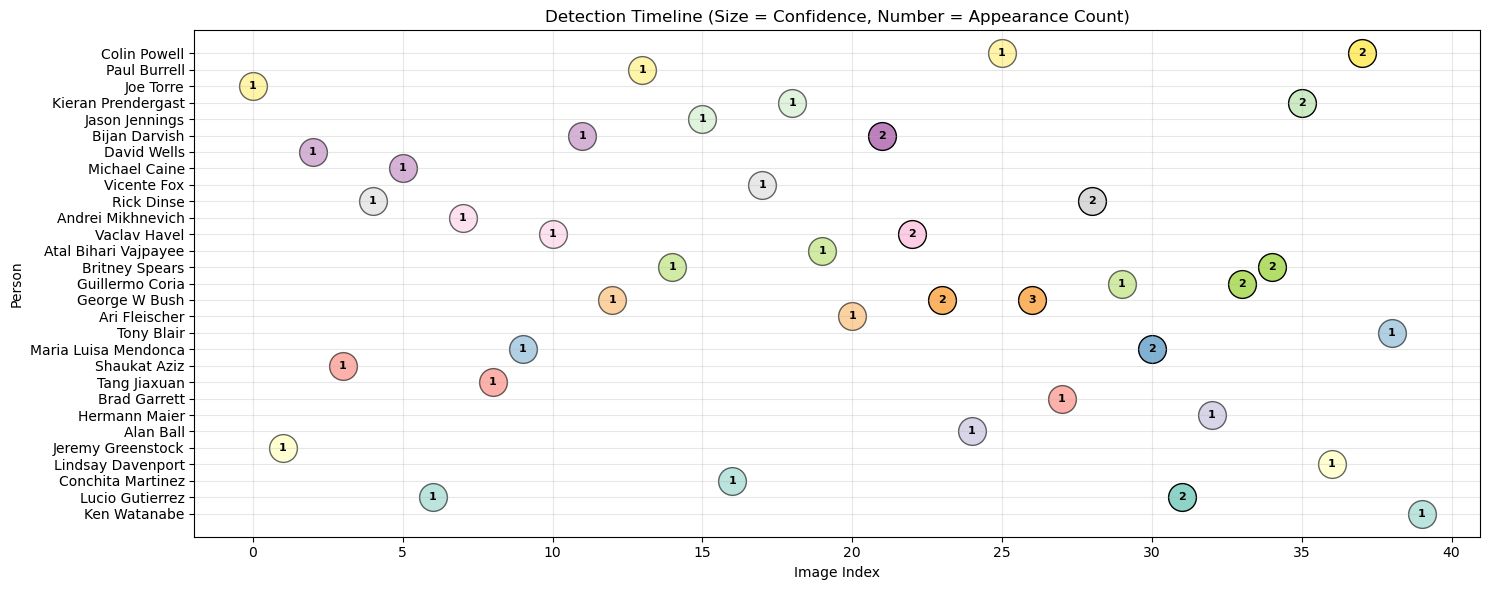

In [31]:
# Cell 7: Show Detection Timeline
# Create detection timeline
print("\n Detection Timeline:")
recognizer.create_detection_timeline()

In [32]:
# Cell 8: Save Model
# Save the trained model
model_filename = "lfw_face_recognizer_notebook.pkl"
recognizer.save_model(model_filename)

print(f"\n System demonstration complete!")
print(f" Model saved as: {model_filename}")
print(f" You can now use this model to identify repeated appearances in new image sequences!")

 Model saved to lfw_face_recognizer_notebook.pkl

 System demonstration complete!
 Model saved as: lfw_face_recognizer_notebook.pkl
 You can now use this model to identify repeated appearances in new image sequences!


In [33]:
# Cell 9: Usage Example for New Images
print("\n Usage Example for New Images:")
print("""
# To use with new images:
new_images = [...]  # Your new image sequence
new_names = [...]   # Optional image names

# Process new sequence
recognizer.process_image_sequence(new_images, new_names)

# Get results
summary = recognizer.get_appearance_summary()
recognizer.visualize_repeated_appearances(new_images)
recognizer.create_detection_timeline()
""")


 Usage Example for New Images:

# To use with new images:
new_images = [...]  # Your new image sequence
new_names = [...]   # Optional image names

# Process new sequence
recognizer.process_image_sequence(new_images, new_names)

# Get results
summary = recognizer.get_appearance_summary()
recognizer.visualize_repeated_appearances(new_images)
recognizer.create_detection_timeline()

